In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import pandas as pd
import datetime
now = datetime.datetime.now
from scipy import stats

In [ ]:
# Load the data
fatigue_df = pd.read_csv("/content/drive/MyDrive/Datasets/Titanium_Alloy_PI.csv", encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,1.199845e+05
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,1.414165e+05
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,3.316557e+05
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,4.734918e+05
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0,2.211821e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,1.801202e+02
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.168016e+02
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.488141e+02
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,3.426198e+02


In [ ]:
fatigue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [ ]:
# Sort the data by ascending order of number of cycles
fatigue_df = fatigue_df.sort_values(by='Number of Cycles')

In [ ]:
fatigue_df.columns

Index(['SL. Number', 'Number of Cycles', 'Stress (MPa)',
       'Solution Temperature (°C)', 'Solution Time (hrs)',
       'Temperature Measurement (°C)', 'Ann/Age. temp (cel)',
       'Ann/age time (hrs)', 'Total Strain (%)', 'R', 'Frequency (Hz)', 'Ti',
       'Al', 'V', 'C', 'N', 'O', 'H', 'Fe', 'Si', 'Sn', 'Nb', 'Mo', 'Zr',
       'PI Fatigue Life'],
      dtype='object')

In [ ]:
from scipy import stats
def outliers(df1, level):

    # 1. temporary dataframe
    df = df1.copy(deep = True)

    # 2. Select a level for a Z-score to identify and remove outliers
    df_Z = df[(np.abs(stats.zscore(df)) < level).all(axis=1)]
    ix_keep = df_Z.index

    # 3. Subset the raw dataframe with the indexes you'd like to keep
    df_keep = df.loc[ix_keep]

    return(df_keep)

In [ ]:
# Removing Outliers
out_df = outliers(fatigue_df, 3)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number']

# Use all remaining columns as features
features = out_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(out_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
184,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.0025,0.00,0.004,0.0,0.340,4.00,0.70,0.500,3.70,1.428483e+02
79,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,1.331221e+02
83,700.06,1025,2.0,400,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,9.944032e+01
81,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,7.944426e+01
80,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,2.796968e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,703.00,0,0.0,25,600,8.0,0.00,0.1,0.0,85.98,...,0.0040,0.03,0.008,0.0,0.000,1.95,0.00,2.000,3.80,2.137039e+07
42,947.76,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.925415e+07
43,846.12,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,5.087448e+07
39,695.53,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.273788e+07


# Model Training

In [ ]:
# rmse loss
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
features.shape

(185, 23)

Run # 1 Fold # 1
Training time: 0:01:02.522742


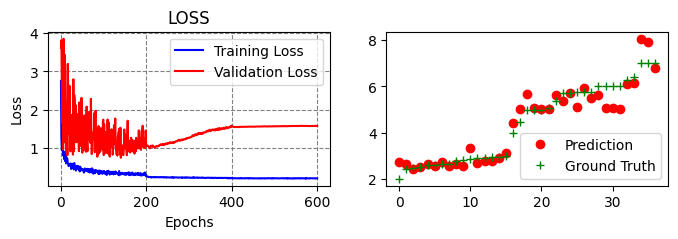

Pearson CC: 0.9608833168175689
R2 score: 0.9216935306469761
RMSE: 0.45384318944951085
MAE: 1.8204050651463113
********************
Run # 1 Fold # 2
Training time: 0:00:58.951944


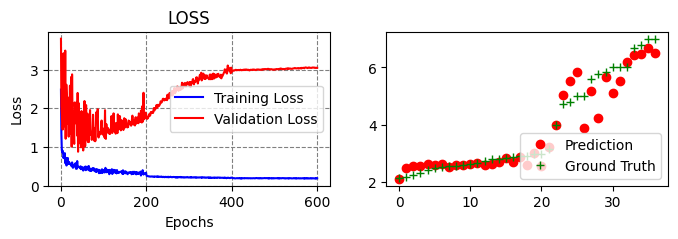

Pearson CC: 0.9645519815415541
R2 score: 0.9250128637549583
RMSE: 0.44604043753656974
MAE: 1.694163958825465
********************
Run # 1 Fold # 3


Training time: 0:00:56.164079


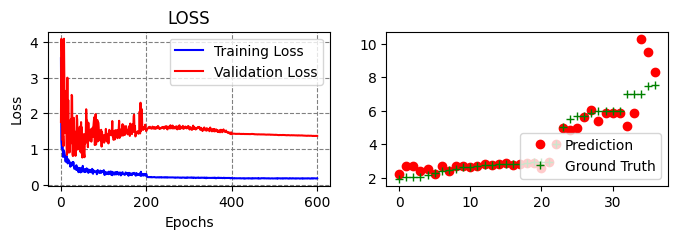

Pearson CC: 0.9217152526154055
R2 score: 0.816427766793049
RMSE: 0.7975022185399011
MAE: 2.055464534182958
********************
Run # 1 Fold # 4
Training time: 0:00:52.138839


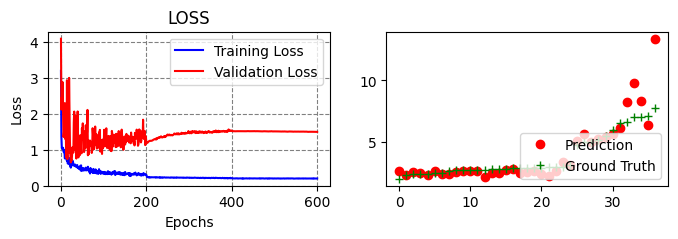

Pearson CC: 0.9283222033939017
R2 score: 0.5555025039850395
RMSE: 1.1378880789923902
MAE: 2.0728183465007075
********************
Run # 1 Fold # 5
Training time: 0:00:58.761979


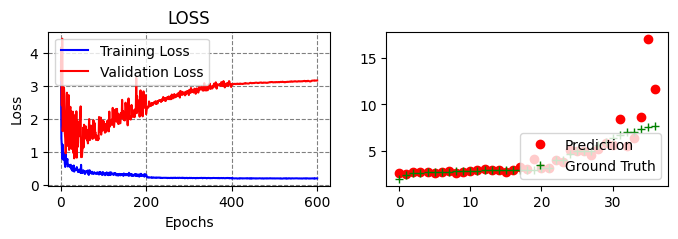

Pearson CC: 0.8378499459336143
R2 score: -0.05595020223636871
RMSE: 1.7746997860209304
MAE: 2.200170922229275
********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)


        for i, (tr, ts) in enumerate(kf.split(targets)):
            targets = targets.reset_index(drop=True)

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # define DNN
            model = Sequential()
            model.add(Input(shape=(23,)))
            model.add(Dense(100,activation='relu'))
            model.add(Dense(200,activation='relu'))
            model.add(Dense(40,activation='relu'))
            model.add(Dense(1,activation='linear'))

            model.compile(optimizer= 'RMSprop', loss=root_mean_squared_error)

            # learning rate scheduler
            import math
            INITIAL_LEARNING_RATE = 0.01
            EPOCHS_NUM = 600
            def lr_step_decay(epoch, lr):
                drop_rate = 0.1
                epochs_drop = 200
                return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

            callbacks=[LearningRateScheduler(lr_step_decay, verbose=0)]

            # Fit model
            t = now()
            history = model.fit(x_train, y_train, batch_size=16, epochs=EPOCHS_NUM,
                                validation_split=0.2, verbose=0, callbacks=callbacks)
            print('Training time: %s' % (now() - t))

            # Plot the loss and the predictions
            train_loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochsn = np.arange(1, len(train_loss)+1,1)
            plt.figure(figsize=(8, 2))
            plt.subplot(1,2,1)
            plt.plot(epochsn,train_loss, 'b', label='Training Loss')
            plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
            plt.grid(color='gray', linestyle='--')
            plt.legend()
            plt.title('LOSS')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.subplot(1,2,2)
            y_pred_test = model.predict(x_test, verbose=0)
            plt.plot(y_pred_test, 'ro', label='Prediction')
            plt.plot(np.array(y_test), 'g+', label='Ground Truth')
            plt.legend(loc=4)
            plt.show()

            # Evaluate metrics
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred_test))[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.960883,0.921694,0.453843,1.820405
1,0.964552,0.925013,0.446040,1.694164
2,0.921715,0.816428,0.797502,2.055465
3,0.928322,0.555503,1.137888,2.072818
4,0.837850,-0.055950,1.774700,2.200171


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.922665,0.045698,0.632537,0.369572,0.921995,0.496973,1.968605,0.184016
